In [57]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_gender_confusion_matrices(predictions, true_labels, gender):
    
    data = pd.DataFrame({
        'true_label': true_labels,
        'predicted_label': predictions,
        'gender': gender
    })
    
    label_order = ['very bad', 'bad', 'average', 'good', 'very good']

    # get labels
    # labels = sorted(data['true_label'].unique())

    # separate data by gender
    male_data = data[data['gender'] == 'male']
    female_data = data[data['gender'] == 'female']

    # compute male confusion matrix
    male_cm = confusion_matrix(male_data['true_label'], male_data['predicted_label'], labels=label_order)
    print("Male Confusion Matrix:\n", male_cm)

    # display male confusion matrix 
    male_disp = ConfusionMatrixDisplay(confusion_matrix=male_cm, display_labels=label_order)
    male_disp.plot()
    plt.title("Male Confusion Matrix")
    plt.show()

    # compute female confusion matrix
    female_cm = confusion_matrix(female_data['true_label'], female_data['predicted_label'], labels=label_order)
    print("Female Confusion Matrix:\n", female_cm)

    # display female confusion matrix
    female_disp = ConfusionMatrixDisplay(confusion_matrix=female_cm, display_labels=label_order)
    female_disp.plot()
    plt.title("Female Confusion Matrix ")
    plt.show()

In [58]:
import pandas as pd

def demographic_parity_difference(predictions, true_labels, gender):

    data = pd.DataFrame({
        'true_label': true_labels,
        'predicted_label': predictions,
        'gender': gender
    })
    
    # get labels
    labels = sorted(data['true_label'].unique())
    
    # separate data by gender
    male_data = data[data['gender'] == 'male']
    female_data = data[data['gender'] == 'female']
    
    # compute total number of items for each gender
    total_male_items = len(male_data)
    total_female_items = len(female_data)

    # init dicts to store TPRs and privileged gender for each label
    privileged_genders = {}
    dpd_dict = {}
    
    for label in labels:

        # find number of positive preds for current label
        male_positives = (male_data['predicted_label'] == label).sum()
        female_positives = (female_data['predicted_label'] == label).sum()

        # compute positive rate for current ethnicity
        male_positive_rate = male_positives / total_male_items if total_male_items > 0 else 0
        female_positive_rate = female_positives / total_female_items if total_male_items > 0 else 0

        privileged_gender = 'male' if male_positive_rate > female_positive_rate else 'female'
        privileged_genders[label] = privileged_gender
        
        # compute demographic parity difference for the current label
        dpd = abs(male_positive_rate - female_positive_rate)
        dpd_dict[label] = dpd


    return dpd_dict, privileged_genders


In [59]:
import pandas as pd

def equal_opportunity_difference(predictions, true_labels, gender):

    data = pd.DataFrame({
        'true_label': true_labels,
        'predicted_label': predictions,
        'gender': gender
    })
    
    # get labels
    labels = sorted(data['true_label'].unique())
    
    # separate data by gender
    male_data = data[data['gender'] == 'male']
    female_data = data[data['gender'] == 'female']
    
    # init dicts to store EOD and privileged gender for each label
    eod_dict = {}
    privileged_genders = {}
    
    for label in labels:
        # compute TPRs for each gender
        male_true_positives = ((male_data['true_label'] == label) & (male_data['predicted_label'] == label)).sum()
        male_condition_positives = (male_data['true_label'] == label).sum()
        male_tpr = male_true_positives / male_condition_positives if male_condition_positives != 0 else 0

        female_true_positives = ((female_data['true_label'] == label) & (female_data['predicted_label'] == label)).sum()
        female_condition_positives = (female_data['true_label'] == label).sum()
        female_tpr = female_true_positives / female_condition_positives if female_condition_positives != 0 else 0
        
        # determine privileged gender based on higher TPR
        privileged_gender = 'male' if male_tpr > female_tpr else 'female'
        
        # computre EOD for current label
        eod = abs(male_tpr - female_tpr)
        
        # store results in dictionaries
        eod_dict[label] = eod
        privileged_genders[label] = privileged_gender
    
    return eod_dict, privileged_genders


In [60]:
import pandas as pd

def average_odds_difference(predictions, true_labels, gender):

    data = pd.DataFrame({
        'true_label': true_labels,
        'predicted_label': predictions,
        'gender': gender
    })
    
    # get labels
    labels = sorted(data['true_label'].unique())
    
    # separate data by gender
    male_data = data[data['gender'] == 'male']
    female_data = data[data['gender'] == 'female']
    
    # init dicts to store AOD and privileged gender for each label
    aod_dict = {}
    privileged_genders = {}
    
    for label in labels:
        # compute TPRs for each gender
        male_true_positives = ((male_data['true_label'] == label) & (male_data['predicted_label'] == label)).sum()
        male_condition_positives = (male_data['true_label'] == label).sum()
        male_tpr = male_true_positives / male_condition_positives if male_condition_positives != 0 else 0

        female_true_positives = ((female_data['true_label'] == label) & (female_data['predicted_label'] == label)).sum()
        female_condition_positives = (female_data['true_label'] == label).sum()
        female_tpr = female_true_positives / female_condition_positives if female_condition_positives != 0 else 0
        
        # compute FPRs for each gender
        male_false_positives = ((male_data['true_label'] != label) & (male_data['predicted_label'] == label)).sum()
        male_condition_negatives = (male_data['true_label'] != label).sum()
        male_fpr = male_false_positives / male_condition_negatives if male_condition_negatives != 0 else 0

        female_false_positives = ((female_data['true_label'] != label) & (female_data['predicted_label'] == label)).sum()
        female_condition_negatives = (female_data['true_label'] != label).sum()
        female_fpr = female_false_positives / female_condition_negatives if female_condition_negatives != 0 else 0
        
        # determine privileged gender based on higher TPR and FPR
        privileged_gender = 'male' if (male_tpr + male_fpr) > (female_tpr + female_fpr) else 'female'
        
        # compute AOD for current label
        aod = 0.5 * (abs(male_tpr - female_tpr) + abs(male_fpr - female_fpr))
        
        # store results in dictionaries
        aod_dict[label] = aod
        privileged_genders[label] = privileged_gender
    
    return aod_dict, privileged_genders

In [61]:
import pandas as pd

def false_discovery_rate_difference(predictions, true_labels, gender):

    data = pd.DataFrame({
        'true_label': true_labels,
        'predicted_label': predictions,
        'gender': gender
    })
    
    # get labels
    labels = sorted(data['true_label'].unique())
    
    # separate data by gender
    male_data = data[data['gender'] == 'male']
    female_data = data[data['gender'] == 'female']
    
    # init dicts to store FDRs and privileged gender for each label
    false_discovery_rates = {}
    privileged_genders = {}
    fdrd_dict = {}
    
    for label in labels:

        # compute FPs and TPs for males
        male_fp = ((male_data['predicted_label'] == label) & (male_data['true_label'] != label)).sum()
        male_tp = ((male_data['predicted_label'] == label) & (male_data['true_label'] == label)).sum()
        
        # compute FPs and TPs for females
        female_fp = ((female_data['predicted_label'] == label) & (female_data['true_label'] != label)).sum()
        female_tp = ((female_data['predicted_label'] == label) & (female_data['true_label'] == label)).sum()
        
        # compute FDR for males and females
        male_fdr = male_fp / (male_fp + male_tp) if (male_fp + male_tp) > 0 else 0
        female_fdr = female_fp / (female_fp + female_tp) if (female_fp + female_tp) > 0 else 0
        
        # determine privileged gender based on higher FDR
        privileged_gender = 'male' if male_fdr > female_fdr else 'female'
        privileged_genders[label] = privileged_gender
        
        # compute FDR difference for current label
        fdrd = abs(male_fdr - female_fdr)
        fdrd_dict[label] = fdrd

    return fdrd_dict, privileged_genders



In [62]:
import pandas as pd

def false_omission_rate_difference(predictions, true_labels, gender):
   
    data = pd.DataFrame({
        'true_label': true_labels,
        'predicted_label': predictions,
        'gender': gender
    })
    
    # get labels
    labels = sorted(data['true_label'].unique())
    
    # Separate data by gender
    male_data = data[data['gender'] == 'male']
    female_data = data[data['gender'] == 'female']
    
    # init dicts to store FORs and privileged gender for each label
    false_omission_rates = {}
    privileged_genders = {}
    ford_dict = {}
    
    for label in labels:

        # compute FNs and TNs for males
        male_fn = ((male_data['predicted_label'] != label) & (male_data['true_label'] == label)).sum()
        male_tn = ((male_data['predicted_label'] != label) & (male_data['true_label'] != label)).sum()
        
        # compute FNs and TNs for females
        female_fn = ((female_data['predicted_label'] != label) & (female_data['true_label'] == label)).sum()
        female_tn = ((female_data['predicted_label'] != label) & (female_data['true_label'] != label)).sum()
        
        # compute FOR for each gender
        male_for = male_fn / (male_fn + male_tn) if (male_fn + male_tn) > 0 else 0
        female_for = female_fn / (female_fn + female_tn) if (female_fn + female_tn) > 0 else 0
        
        # determine privileged gender based on lower FOR
        privileged_gender = 'male' if male_for < female_for else 'female'
        privileged_genders[label] = privileged_gender
        
        # compute fFOR difference for current label
        ford = abs(male_for - female_for)
        ford_dict[label] = ford
    
    return ford_dict, privileged_genders


In [63]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


# load train and test datasets separately
datatrain = pd.read_csv('Data/gender_biased_final.csv')
data_train = datatrain.sample(frac=0.8, random_state=42)

datatest = pd.read_csv('Data/balanced_resumes_final.csv')
data_test = datatest.sample(frac=0.2, random_state=42)

# drop rows with missing values in text columns
text_columns = ['Name', 'Education', 'Work Experience', 'Skills', 'Awards']
data_train = data_train.dropna(subset=text_columns)
data_test = data_test.dropna(subset=text_columns)

# extract text data and labels separately
X_train_text = data_train['Name'] + ' ' + data_train['Education'] + ' ' + data_train['Work Experience'] + ' ' + data_train['Skills'] + ' ' + data_train['Awards']
y_train = data_train['Fit']
gender_train = data_train['Gender']
ethnicity_train = data_train['Ethnicity']

X_test_text = data_test['Name'] + ' ' + data_test['Education'] + ' ' + data_test['Work Experience'] + ' ' + data_test['Skills'] + ' ' + data_test['Awards']
y_test = data_test['Fit']
gender_test = data_test['Gender']
ethnicity_test = data_test['Ethnicity']

# vectorize the text data with TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)


Accuracy: 0.5748031496062992
              precision    recall  f1-score   support

     average       0.57      0.51      0.54        69
         bad       0.56      0.55      0.56        40
        good       0.42      0.46      0.44        59
    very bad       0.79      0.73      0.76        37
   very good       0.64      0.71      0.67        49

    accuracy                           0.57       254
   macro avg       0.60      0.59      0.59       254
weighted avg       0.58      0.57      0.58       254

Male Confusion Matrix:
 [[ 5  9  0  0  0]
 [ 0 13 10  0  0]
 [ 0  0 17 17  1]
 [ 0  0  1 10 16]
 [ 0  0  0  3 26]]


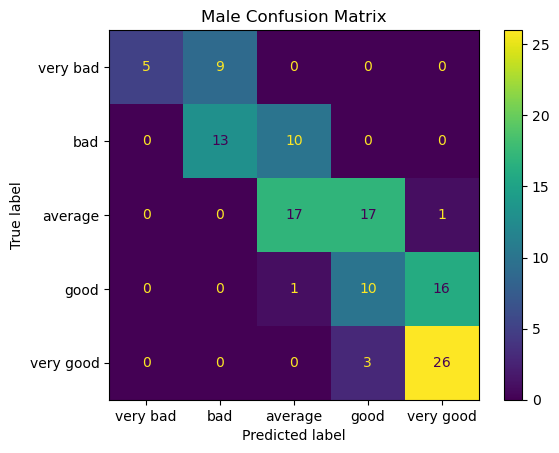

Female Confusion Matrix:
 [[22  0  1  0  0]
 [ 7  9  1  0  0]
 [ 0  8 18  7  1]
 [ 0  0 13 17  2]
 [ 0  0  0 11  9]]


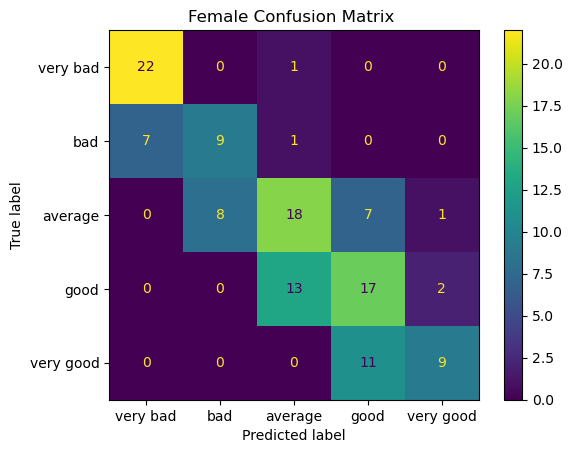

In [65]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

n_iterations = 10  # nr of bootstrap samples
n_size = X_train.shape[0]  # nr of samples in the training set

# convert y_train to a numpy array
y_train_array = y_train.to_numpy()

# list to store accuracy for each bootstrap sample
bootstrap_svm = {}

# bootstrap resampling
for i in range(n_iterations):
    # generate bootstrap sample
    indices = np.random.choice(np.arange(n_size), size=n_size, replace=True)
    X_train_resample = X_train[indices]
    y_train_resample = y_train_array[indices]
    
    
    # train SVM model on bootstrap sample
    svm_classifier = SVC(kernel='linear', C=1.7)
    svm_classifier.fit(X_train_resample, y_train_resample)
    
    # predict on test set
    y_pred_svm = svm_classifier.predict(X_test)
    bootstrap_svm[i] = y_pred_svm

accuracy = accuracy_score(y_test, bootstrap_svm[0])
print("Accuracy:", accuracy)
print(classification_report(y_test, bootstrap_svm[0]))
plot_gender_confusion_matrices(bootstrap_svm[0], y_test, gender_test)



Accuracy: 0.5669291338582677
              precision    recall  f1-score   support

     average       0.54      0.42      0.47        69
         bad       0.68      0.75      0.71        40
        good       0.38      0.41      0.39        59
    very bad       0.87      0.70      0.78        37
   very good       0.56      0.71      0.62        49

    accuracy                           0.57       254
   macro avg       0.60      0.60      0.60       254
weighted avg       0.58      0.57      0.57       254

Male Confusion Matrix:
 [[ 5  8  1  0  0]
 [ 1 18  4  0  0]
 [ 0  0 14 18  3]
 [ 0  0  3 13 11]
 [ 0  0  0  6 23]]


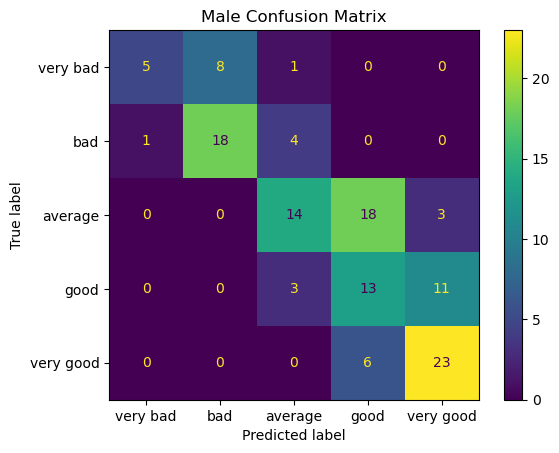

Female Confusion Matrix:
 [[21  1  1  0  0]
 [ 3 12  1  1  0]
 [ 0  5 15  6  8]
 [ 0  0 15 11  6]
 [ 0  0  0  8 12]]


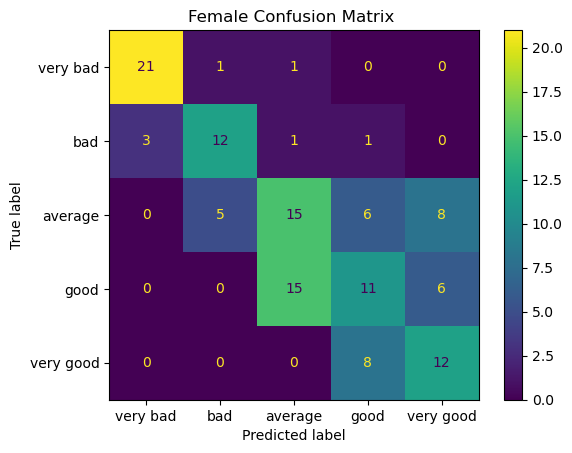

In [66]:
n_iterations = 10  # nr of bootstrap samples
n_size = X_train.shape[0]  # nr of samples in the training set

# convert y_train to a numpy array
y_train_array = y_train.to_numpy()

# list to store accuracy for each bootstrap sample
bootstrap_lr = {}

# bootstrap resampling
for i in range(n_iterations):
    # generate bootstrap sample
    indices = np.random.choice(np.arange(n_size), size=n_size, replace=True)
    X_train_resample = X_train[indices]
    y_train_resample = y_train_array[indices]
    
    
    # train SVM model on bootstrap sample
    logistic_classifier = LogisticRegression(max_iter=1000)
    logistic_classifier.fit(X_train_resample, y_train_resample)
    
    # predict on the test set
    y_pred_lr = logistic_classifier.predict(X_test)
    bootstrap_lr[i] = y_pred_lr

accuracy = accuracy_score(y_test, bootstrap_lr[0])
print("Accuracy:", accuracy)
print(classification_report(y_test, bootstrap_lr[0]))
plot_gender_confusion_matrices(bootstrap_lr[0], y_test, gender_test)
    


Accuracy: 0.5669291338582677
              precision    recall  f1-score   support

     average       0.51      0.51      0.51        69
         bad       0.49      0.62      0.55        40
        good       0.41      0.34      0.37        59
    very bad       0.83      0.68      0.75        37
   very good       0.70      0.80      0.74        49

    accuracy                           0.57       254
   macro avg       0.59      0.59      0.58       254
weighted avg       0.57      0.57      0.56       254

Male Confusion Matrix:
 [[ 5  9  0  0  0]
 [ 1 14  8  0  0]
 [ 0  0 17 18  0]
 [ 0  1  5  7 14]
 [ 0  0  0  2 27]]


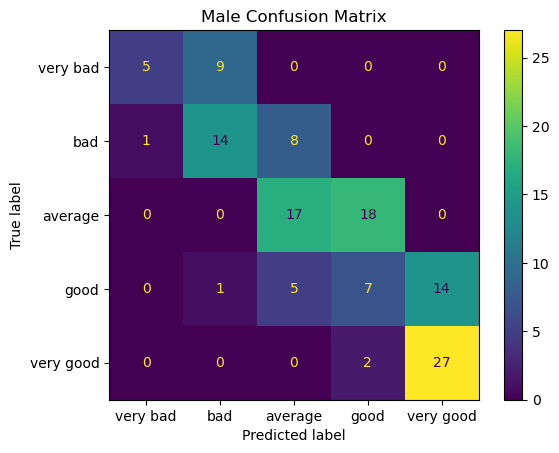

Female Confusion Matrix:
 [[20  3  0  0  0]
 [ 4 11  2  0  0]
 [ 0 13 18  1  2]
 [ 0  0 18 13  1]
 [ 0  0  0  8 12]]


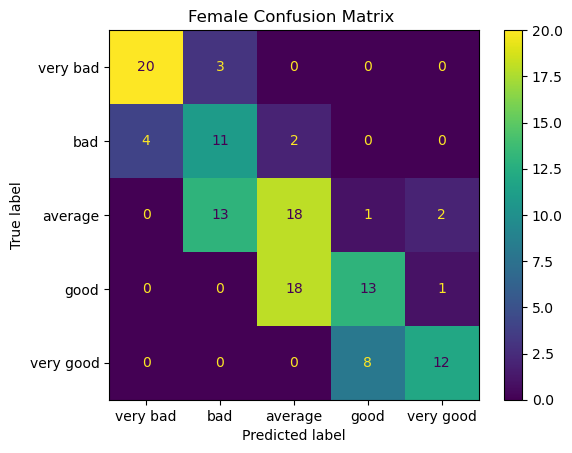

In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample

# list to store preds
bootstrap_rf = []

# generate 10 different sets of predictions
for i in range(10):
    # bootstrap sampling of the training data
    X_train_resampled, y_train_resampled = resample(X_train, y_train)
    
    # init classifier
    rf_classifier = RandomForestClassifier(n_estimators=90)
    
    # fit classifier on the resampled training data
    rf_classifier.fit(X_train_resampled, y_train_resampled)
    
    # pred on test set
    y_pred_rf = rf_classifier.predict(X_test)
    
    # append predictions to list
    bootstrap_rf.append(y_pred_rf.tolist())

accuracy = accuracy_score(y_test, bootstrap_rf[0])
print("Accuracy:", accuracy)
print(classification_report(y_test, bootstrap_rf[0]))
plot_gender_confusion_matrices(bootstrap_rf[0], y_test, gender_test)


Accuracy: 0.5787401574803149
              precision    recall  f1-score   support

     average       0.56      0.48      0.52        69
         bad       0.65      0.75      0.70        40
        good       0.37      0.32      0.35        59
    very bad       0.83      0.81      0.82        37
   very good       0.56      0.71      0.63        49

    accuracy                           0.58       254
   macro avg       0.60      0.62      0.60       254
weighted avg       0.57      0.58      0.57       254

Male Confusion Matrix:
 [[ 8  6  0  0  0]
 [ 1 18  4  0  0]
 [ 0  0 15 17  3]
 [ 0  0  5  6 16]
 [ 0  0  1  3 25]]


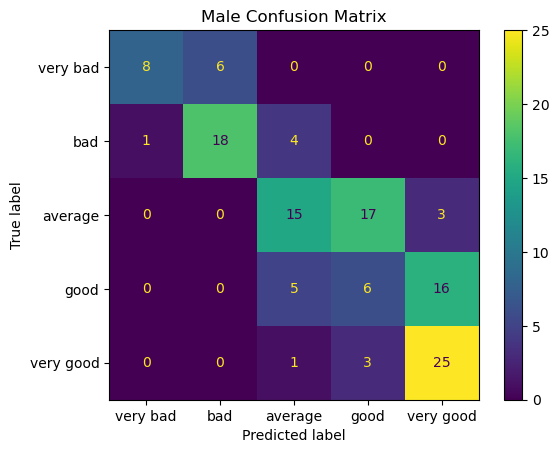

Female Confusion Matrix:
 [[22  1  0  0  0]
 [ 5 12  0  0  0]
 [ 0  9 18  2  5]
 [ 0  0 16 13  3]
 [ 0  0  0 10 10]]


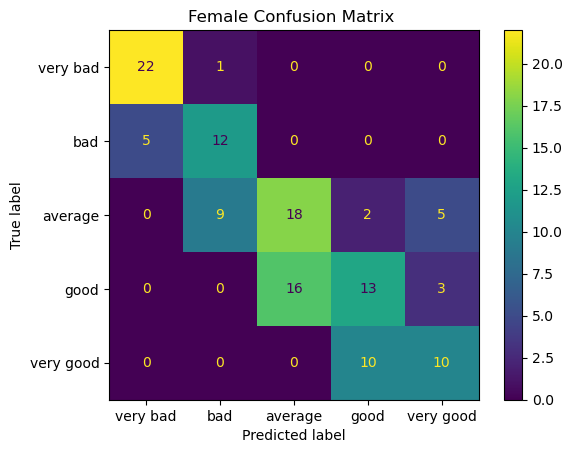

In [68]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils import resample

# list to store preds
bootstrap_gb = []

# generate 10 different sets of predictions
for i in range(10):
    # bootstrap sampling of training data
    X_train_resampled, y_train_resampled = resample(X_train, y_train, random_state=i)
    
    # initialize classifier
    gb_classifier = GradientBoostingClassifier(n_estimators=90)
    
    # fit classifier on the resampled training data
    gb_classifier.fit(X_train_resampled, y_train_resampled)
    
    # predict on the test set
    y_pred_gb = gb_classifier.predict(X_test)
    
    # append preds to the list
    bootstrap_gb.append(y_pred_gb.tolist())

accuracy = accuracy_score(y_test, bootstrap_gb[0])
print("Accuracy:", accuracy)
print(classification_report(y_test, bootstrap_gb[0]))
plot_gender_confusion_matrices(bootstrap_gb[0], y_test, gender_test)


In [69]:
from tabulate import tabulate

# aggregates scores of the 5 metrics
def process_data(tuples):
    scores = {}
    privileged_genders = {}

    # define the list of labels and metrics
    labels = ['average', 'bad', 'good', 'very bad', 'very good']
    metrics = ['DPD', 'EOD', 'AOD', 'FDR', 'FOR']

    # init lists to store the scores and privileged genders
    for label in labels:
        scores[label] = []
        privileged_genders[label] = []

    # loop through  tuples
    for t in tuples:
        for label in labels:
            scores[label].append(t[0][label])
            privileged_genders[label].append(t[1][label])

    return scores, privileged_genders

# prints tables with the specific per-metric bias scores
def print_tables(scores, privileged_genders):
    labels = ['average', 'good', 'bad', 'very good', 'very bad']
    metrics = ['DPD', 'EOD', 'AOD', 'FDR', 'FOR']

    for label in labels:
        data = []
        for i, score in enumerate(scores[label]):
            data.append([metrics[i], score, privileged_genders[label][i]])
        print(f"Table for label '{label}':")
        print(tabulate(data, headers=['Metric', 'Value', 'Privileged Gender'], tablefmt='grid', numalign='left'))
        print("\n")

In [70]:

# compute weighted sum of the 5 bias scores for each gender -> will be used for the average of metrics, but divided by 5 later
def compute_gender_weighted_sums(list_of_dict_pairs):
    
    # init a dictionary to store the sums for each label
    label_sums = {}

    # iterate over each list of dictionary pairs
    for dict_pair in list_of_dict_pairs:
        values_dict, gender_dict = dict_pair
        
        # iterate over each label in the values dictionary
        for label, value in values_dict.items():
            # determine the gender and adjust the sum accordingly
            gender = gender_dict[label]
            if gender == 'male':
                label_sums[label] = label_sums.get(label, 0) + value
            elif gender == 'female':
                label_sums[label] = label_sums.get(label, 0) - value

    return label_sums

# computes weighted sum per gender based on label advantage
def compute_weighted_sums(data):
    # define the weights
    weights = {
        'very bad': -2,
        'bad': -1,
        'average': 0,
        'good': 1,
        'very good': 2
    }
    
    female_sum = 0
    male_sum = 0
    
    # iterate over the data
    for label, value in data.items():
        weight = weights.get(label, 0)  # get weight for the current label
        
        if value < 0:  # if value is negative, add to female sum
            female_sum += abs(value) * weight
        elif value > 0:  # if value is positive, add to male sum
            male_sum += value * weight
    
    return female_sum, male_sum



In [71]:
n = 0 #code below ran for n between 0 and 10 for the 10 runs, for each model

# computes all metrics for the n-th set of predictions
dpd_svm = demographic_parity_difference(bootstrap_svm[n], y_test, gender_test)
eod_svm = equal_opportunity_difference(bootstrap_svm[n], y_test, gender_test)
aod_svm = average_odds_difference(bootstrap_svm[n], y_test, gender_test)
fdr_svm = false_discovery_rate_difference(bootstrap_svm[n], y_test, gender_test)
for_svm = false_omission_rate_difference(bootstrap_svm[n], y_test, gender_test)

# puts all metrics into one variable
tuples_svm = (dpd_svm, eod_svm, aod_svm, fdr_svm, for_svm)

# dpd_lr = demographic_parity_difference(bootstrap_lr[n], y_test, gender_test)
# eod_lr = equal_opportunity_difference(bootstrap_lr[n], y_test, gender_test)
# aod_lr = average_odds_difference(bootstrap_lr[n], y_test, gender_test)
# fdr_lr = false_discovery_rate_difference(bootstrap_lr[n], y_test, gender_test)
# for_lr = false_omission_rate_difference(bootstrap_lr[n], y_test, gender_test)
# tuples_lr = (dpd_lr, eod_lr, aod_lr, fdr_lr, for_lr)

# dpd_rf = demographic_parity_difference(bootstrap_rf[n], y_test, gender_test)
# eod_rf = equal_opportunity_difference(bootstrap_rf[n], y_test, gender_test)
# aod_rf = average_odds_difference(bootstrap_rf[n], y_test, gender_test)
# fdr_rf = false_discovery_rate_difference(bootstrap_rf[n], y_test, gender_test)
# for_rf = false_omission_rate_difference(bootstrap_rf[n], y_test, gender_test)
# tuples_rf = (dpd_rf, eod_rf, aod_rf, fdr_rf, for_rf)

# dpd_gb = demographic_parity_difference(bootstrap_gb[n], y_test, gender_test)
# eod_gb = equal_opportunity_difference(bootstrap_gb[n], y_test, gender_test)
# aod_gb = average_odds_difference(bootstrap_gb[n], y_test, gender_test)
# fdr_gb = false_discovery_rate_difference(bootstrap_gb[n], y_test, gender_test)
# for_gb = false_omission_rate_difference(bootstrap_gb[n], y_test, gender_test)
# tuples_gb = (dpd_gb, eod_gb, aod_gb, fdr_gb, for_gb)

In [72]:
#prints the bias value per metric, along with the privileged gender
print('SVM')
scores_svm, genders_svm = process_data(tuples_svm)
print_tables(scores_svm, genders_svm)

# print('LR')
# scores_lr, genders_lr = process_data(tuples_lr)
# print_tables(scores_lr, genders_lr)

# print('RF')
# scores_rf, genders_rf = process_data(tuples_rf)
# print_tables(scores_rf, genders_rf)

# print('GB')
# scores_gb, genders_gb = process_data(tuples_gb)
# print_tables(scores_gb, genders_gb)

SVM
Table for label 'average':
+----------+------------+---------------------+
| Metric   | Value      | Privileged Gender   |
+==========+============+=====================+
| DPD      | 0.0431548  | female              |
+----------+------------+---------------------+
| EOD      | 0.0436975  | female              |
+----------+------------+---------------------+
| AOD      | 0.0442307  | female              |
+----------+------------+---------------------+
| FDR      | 0.0616883  | female              |
+----------+------------+---------------------+
| FOR      | 0.00795699 | female              |
+----------+------------+---------------------+


Table for label 'good':
+----------+------------+---------------------+
| Metric   | Value      | Privileged Gender   |
+==========+============+=====================+
| DPD      | 0.0434028  | female              |
+----------+------------+---------------------+
| EOD      | 0.16088    | female              |
+----------+------------+------

In [73]:
result_svm = compute_gender_weighted_sums(tuples_svm) # computes metric average for each gender
weighted_sums = compute_weighted_sums(result_svm) # computes weighted sum per gender based on label advantage
diff = abs(weighted_sums[0] - weighted_sums[1]) # diff in privilege between gender
print('SVM')
print(diff/5) # now divided by 5 as it wasn't possible before due to the dictionary format
if weighted_sums[0] > weighted_sums[1]: # prints the privileged gender
    print('female')
else:
    print('male')

# result_lr = compute_gender_weighted_sums(tuples_lr)
# weighted_sums = compute_weighted_sums(result_lr)
# diff = abs(weighted_sums[0] - weighted_sums[1])
# print('LR')
# print(diff/5)
# if weighted_sums[0] > weighted_sums[1]:
#     print('female')
# else:
#     print('male')

# result_rf = compute_gender_weighted_sums(tuples_rf)
# weighted_sums = compute_weighted_sums(result_rf)
# diff = abs(weighted_sums[0] - weighted_sums[1])
# print('RF')
# print(diff/5)
# if weighted_sums[0] > weighted_sums[1]:
#     print('female')
# else:
#     print('male')

# result_gb = compute_gender_weighted_sums(tuples_gb)
# weighted_sums = compute_weighted_sums(result_gb)
# diff = abs(weighted_sums[0] - weighted_sums[1])
# print('GB')
# print(diff/5)
# if weighted_sums[0] > weighted_sums[1]:
#     print('female')
# else:
#     print('male')


SVM
1.0151424002526004
male


In [79]:
import numpy as np

# positive values represent predicitons where the male candidates are privileged. When female candidates are privileged, they keep their absolute value but become negative
l = [0.6589482613370713, 0.9934564540287084, 0.8800857798299354, 0.6676379992589274, 0.6602748627376511,
     0.881157271975294, 0.8765420920313793, 0.69195658882815, 0.8790023360427899, 0.6719486586079777]

sample_standard_deviation = np.std(l, ddof=1)  # sample standard deviation with Bessel's correction
sem = sample_standard_deviation / np.sqrt(10)

# prints standard deviation for the bias measure, /6 for normalisation
print('margin of error for bias:')
print(sem/6)

# prints mean of values, /6 for normalisation
print('mean of bias value:')
print(np.mean(l)/6)


margin of error for bias:
0.006703666144470617
mean of bias value:
0.13101683841129808


In [80]:
all_accs = []
for n in range(10):
    accuracy = accuracy_score(y_test, bootstrap_svm[n]) # do with all models 
    all_accs.append(accuracy)

sample_standard_deviation = np.std(all_accs, ddof=1)  # sample standard deviation with Bessel's correction
sem = sample_standard_deviation / np.sqrt(5)

# print standard deviation for accuracies 
print('margin of error for accuracy:')
print(sem)

# prints average of accuracies
print('accuracy mean:')
print(np.mean(all_accs))


margin of error for accuracy:
0.008425564787020742
accuracy mean:
0.5641732283464567
